# Author: Arta Khosravi
## Last Update: April 2024
### GitHub link: <a href="https://github.com/artakh10/Accretion-efficiency">Accretion disk efficiency</a>


---

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import pandas as pd
import scipy as sy
import sympy as sp
import seaborn as sns
from constants_Acc import *
from function_Acc import *
from pylab import *
from scipy.optimize import curve_fit, minimize_scalar
import scipy.signal as sig
from scipy.interpolate import UnivariateSpline
# from symfit import parameters, variables, log, Fit, Model,Poly
import plotly.express as px
from pylab import *
import lmfit
import warnings
warnings.filterwarnings('ignore', '.*tight_layout.*',)

## Volume and flux limit correction for data

In [127]:
pd.set_option('display.max_columns', None)
vol = pd.read_csv('flux_vol_eps_bins_2.5.csv')
vol_standard=vol[(10**vol['log_edd_ratio']<=1) | (1e-2<=10**vol['log_edd_ratio'])]
vol_standard['epsopt_3000']=(Epsilonopt(10**(vol_standard['log_lbol']),
                                       10**(vol_standard['log_bh']),10**(vol_standard['l_3000'])))
vol_standard['epsopt_1350']=(Epsilonopt(10**(vol_standard['log_lbol']),
                                       10**(vol_standard['log_bh']),10**(vol_standard['l_1350'])))
vol_standard['epsopt_1700']=(Epsilonopt(10**(vol_standard['log_lbol']),
                                       10**(vol_standard['log_bh']),10**(vol_standard['l_1700'])))
vol_standard

,Unnamed: 0,name,z,log_bh,log_lbol,log_edd_ratio,m_app_bol,m_app_lim,M_bol,M_abs_lim,dist,l_3000,l_1350,l_1700,l_5100,eps_5100,eps_3000,eps_1350,eps_1700,L_L,L_max_col,eps_min_col,epsopt_3000,epsopt_1350,epsopt_1700
0,0,SDSS J0005-0006,5.8440,8.000000,46.670246,0.556303,20.794011,24.224476,-27.930465,-27.024726,55577.014461,45.958439,inf,inf,inf,inf,0.010598,inf,inf,0.640560,inf,0.010598,0.010598,0.000000,0.0
1,1,SDSS J1411+1217,5.8540,8.954243,47.182129,0.113943,19.518620,24.228794,-29.210173,-27.029044,55687.626897,46.470322,inf,inf,inf,inf,0.041062,inf,inf,0.640564,inf,0.041062,0.041062,0.000000,0.0
2,2,SDSS J1411+1217,5.8540,8.954243,47.182129,0.113943,19.518620,24.228794,-29.210173,-27.029044,55687.626897,46.470322,inf,inf,inf,inf,0.041062,inf,inf,0.640564,inf,0.041062,0.041062,0.000000,0.0
3,3,SDSS J1411+1217,5.9030,9.204120,47.272306,-0.045757,19.314224,24.249838,-29.435615,-27.050089,56229.943014,46.560499,inf,inf,inf,inf,0.061637,inf,inf,0.640582,inf,0.061637,0.061637,0.000000,0.0
4,4,SDSS J1411+1217,5.9030,9.204120,47.272306,-0.045757,19.314224,24.249838,-29.435615,-27.050089,56229.943014,46.560499,inf,inf,inf,inf,0.061637,inf,inf,0.640582,inf,0.061637,0.061637,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,88,VIKING J234833.34-305410.0,6.9018,9.296665,46.633468,-0.769551,21.304462,24.642983,-27.838521,-27.443233,67390.167868,45.954243,inf,inf,inf,inf,0.140975,inf,inf,0.640888,inf,0.140975,0.140975,0.000000,0.0
89,89,ULAS J1120+0641,7.1000,9.208819,47.174205,-0.318759,20.023519,24.713882,-29.190363,-27.514132,69626.798140,46.462398,46.623249,inf,inf,inf,0.069832,0.040066,inf,0.640939,inf,0.040066,0.069832,0.040066,0.0
90,90,VIKING J234833.34-305410.0,6.9000,9.322219,46.684935,-0.744727,21.175141,24.642329,-27.967188,-27.442579,67369.886603,45.973128,inf,inf,inf,inf,0.156498,inf,inf,0.640888,inf,0.156498,0.156498,0.000000,0.0
91,91,VIKING J010953.13-304726.3,6.7000,9.031291,46.741191,-0.619789,20.960745,24.568572,-28.107828,-27.368822,65120.004719,46.029384,46.143015,inf,inf,inf,0.080704,0.054506,inf,0.640833,inf,0.054506,0.080704,0.054506,0.0


In [166]:
vol_standard.fillna(np.inf, inplace=True)
#Finding max for L
df_L_min_vol = np.empty(len(vol_standard.index), dtype="O")
L_min_columns = vol_standard[['l_1700', 'l_3000','l_1350']].idxmin(axis=1)
for i, (r, c) in enumerate(zip(vol_standard.index, L_min_columns)):
    df_L_min_vol[i] = vol_standard._get_value(r, c)
vol_standard['L_min_col'] = df_L_min_vol
#Finding min for epsilon
vol_standard.fillna(np.inf, inplace=True)
vol_standard['epsopt_3000'] = vol_standard['epsopt_3000'].replace(0, np.nan)
vol_standard['epsopt_1700'] = vol_standard['epsopt_1700'].replace(0, np.nan)
vol_standard['epsopt_1350'] = vol_standard['epsopt_1350'].replace(0, np.nan)
eps_min_columns_vol = vol_standard[['epsopt_3000','epsopt_1700','epsopt_1350']].idxmin(axis=1)
eps_vol_min_list = np.empty(len(vol_standard.index),dtype="O")
for i, (r, c) in enumerate(zip(vol_standard.index, eps_min_columns_vol)):
    eps_vol_min_list[i] = vol_standard._get_value(r, c)
vol_standard['eps_min_total'] = eps_vol_min_list
vol_standard=vol_standard.drop_duplicates(subset='eps_min_col')
vol_standard.fillna(np.inf, inplace=True)
vol_standard['eps_min_col'] = vol_standard['eps_min_col'].replace(np.inf, np.nan)
vol_standard=vol_standard[(vol_standard['eps_min_col'].notna())].reset_index(drop=True)
vol_standard
# vol_standard.drop_duplicates(subset='eps_min_col')

,Unnamed: 0,name,z,log_bh,log_lbol,log_edd_ratio,m_app_bol,m_app_lim,M_bol,M_abs_lim,dist,l_3000,l_1350,l_1700,l_5100,eps_5100,eps_3000,eps_1350,eps_1700,L_L,L_max_col,eps_min_col,epsopt_3000,epsopt_1350,epsopt_1700,L_min_col,eps_min_total
0,0,SDSS J0005-0006,5.8440,8.000000,46.670246,0.556303,20.794011,24.224476,-27.930465,-27.024726,55577.014461,45.958439,inf,inf,inf,inf,0.010598,inf,inf,0.640560,inf,0.010598,0.010598,inf,inf,45.958439,0.010598
1,1,SDSS J1411+1217,5.8540,8.954243,47.182129,0.113943,19.518620,24.228794,-29.210173,-27.029044,55687.626897,46.470322,inf,inf,inf,inf,0.041062,inf,inf,0.640564,inf,0.041062,0.041062,inf,inf,46.470322,0.041062
2,3,SDSS J1411+1217,5.9030,9.204120,47.272306,-0.045757,19.314224,24.249838,-29.435615,-27.050089,56229.943014,46.560499,inf,inf,inf,inf,0.061637,inf,inf,0.640582,inf,0.061637,0.061637,inf,inf,46.560499,0.061637
3,5,SDSS J1306+0356,6.0170,9.230449,47.122544,-0.221849,19.736891,24.298100,-29.061209,-27.098350,57493.657912,46.410736,inf,inf,inf,inf,0.077563,inf,inf,0.640622,inf,0.077563,0.077563,inf,inf,46.410736,0.077563
4,7,SDSS J1306+0356,6.0180,9.462398,47.053463,-0.522879,19.910012,24.298519,-28.888507,-27.098769,57504.755357,46.341655,inf,inf,inf,inf,0.135307,inf,inf,0.640622,inf,0.135307,0.135307,inf,inf,46.341655,0.135307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,88,VIKING J234833.34-305410.0,6.9018,9.296665,46.633468,-0.769551,21.304462,24.642983,-27.838521,-27.443233,67390.167868,45.954243,inf,inf,inf,inf,0.140975,inf,inf,0.640888,inf,0.140975,0.140975,inf,inf,45.954243,0.140975
72,89,ULAS J1120+0641,7.1000,9.208819,47.174205,-0.318759,20.023519,24.713882,-29.190363,-27.514132,69626.798140,46.462398,46.623249,inf,inf,inf,0.069832,0.040066,inf,0.640939,inf,0.040066,0.069832,0.040066,inf,46.462398,0.040066
73,90,VIKING J234833.34-305410.0,6.9000,9.322219,46.684935,-0.744727,21.175141,24.642329,-27.967188,-27.442579,67369.886603,45.973128,inf,inf,inf,inf,0.156498,inf,inf,0.640888,inf,0.156498,0.156498,inf,inf,45.973128,0.156498
74,91,VIKING J010953.13-304726.3,6.7000,9.031291,46.741191,-0.619789,20.960745,24.568572,-28.107828,-27.368822,65120.004719,46.029384,46.143015,inf,inf,inf,0.080704,0.054506,inf,0.640833,inf,0.054506,0.080704,0.054506,inf,46.029384,0.054506


In [167]:
df_standard = df_standard.replace([np.inf], np.nan)
df_art = pd.DataFrame({
'Object': df_standard['name'],
'z': df_standard['z'],
'log_bh': df_standard['log_bh'],
'log_lbol': df_standard['log_lbol'],
'log_edd_ratio': df_standard['log_edd_ratio'],
'L_min_col': df_standard['L_min_col'],
'epsopt': df_standard['eps_min_col']
})
df_art=df_art.round(3)
df_art=df_art[(df_art['epsopt'].notna())].reset_index(drop=True)
df_art=df_art.drop_duplicates().reset_index(drop=True)
df_art.to_csv('vol_article.csv',index=False)

In [187]:
vol_standard = vol_standard.replace([np.inf], np.nan)
vol_standard_nonan=pd.DataFrame({'z':vol_standard['z'],'log_bh':vol_standard['log_bh'],'epsopt':vol_standard['eps_min_col']})
vol_standard_nonan=vol_standard_nonan[(vol_standard_nonan['epsopt'].notna())]
vol_standard_nonan.drop_duplicates()

,z,log_bh,epsopt
0,5.8440,8.000000,0.010598
1,5.8540,8.954243,0.041062
2,5.9030,9.204120,0.061637
3,6.0170,9.230449,0.077563
4,6.0180,9.462398,0.135307
...,...,...,...
71,6.9018,9.296665,0.140975
72,7.1000,9.208819,0.040066
73,6.9000,9.322219,0.156498
74,6.7000,9.031291,0.054506


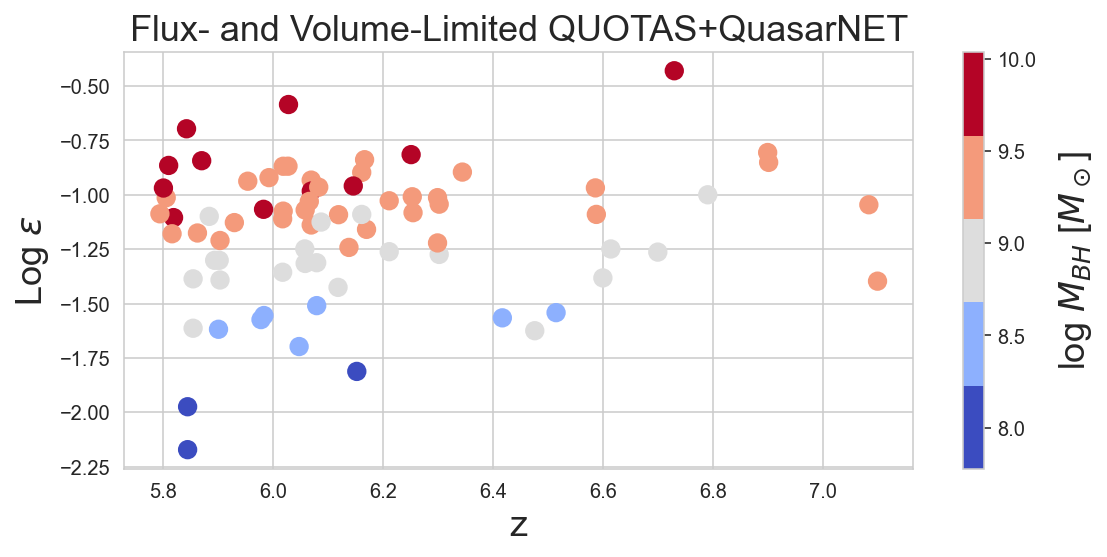

In [170]:
cmap = cm.get_cmap('coolwarm',5)
fig,ax= plt.subplots(figsize=(8, 4))
points = plt.scatter(x=df_standard_nonan.z, y=np.log10(df_standard_nonan.epsopt), c=df_standard_nonan.log_bh,s=75, 
                     cmap=cmap,label=' flux and volume limited QUOTAS + QuasarNET data points')
cbar=plt.colorbar(points)
cbar.set_label('$M_{BH}$', labelpad=10,size=13)
# plt.ylim(0,0.5)
# plt.legend(loc='best')
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
plt.xlabel('z',size=18)
plt.title('Flux- and Volume-Limited QUOTAS+QuasarNET',size=18)
plt.ylabel('Log $\epsilon$',size=18)
plt.tight_layout()
plt.savefig('76_18_log_QN_vol_epsilon_vs_z_MBH_colored.pdf',dpi=600)
plt.show()

## DL11 data

In [183]:
D11=pd.read_csv('DR11.csv')
D11['epsilon_obsv']=10**(D11['logeps'])
D11['epsopt']=10**(D11['logeps'])
cols11=[4,6,8,11]
D11.drop(D11.columns[cols11],axis=1,inplace=True)
D11=D11.reset_index(drop=True)
Mbh_D11=[];eps_D11=[];Ledd_D11=[];edd_ratio_D11=[];
for i in range(len(D11)):
    Mbh_D11.append(MBHD11(D11['logLoptb'][i],D11['LogMdot'][i]))
for i in range(len(D11)):
    eps_D11.append(EpsilonKopt(10**D11['logLbolb'][i],10**D11['log_bh'][i],10**D11['logLoptb'][i]))
    Ledd_D11.append(Ledd(10**D11['log_bh'][i]))
    edd_ratio_D11.append(eddration(10**D11['log_bh'][i],10**D11['logLbolb'][i]))
# D11['Eps_Kopt']=eps_D11
D11['epsopt_lambda']=(Epsilonopt(10**(D11['logLbolb']),
                                       10**(D11['log_bh']),10**(D11['logLoptb'])))
for i in range(len(D11)):
    if D11['epsilon_obsv'][i]>10:
        D11=D11.drop([i])
D11=D11.drop_duplicates()
D11_standard=D11[(10**D11['log_edd_ratio']<=1) | (1e-2<=10**D11['log_edd_ratio'])].dropna()
D11_standard

,Object,z,log_bh,log_edd_ratio,logLoptb,LogMdot,logLbolb,logeps,epsilon_obsv,epsopt,epsopt_lambda
0,0003 + 158,0.4505,9.055,-0.358,45.87,0.79,46.92,-0.52,0.301995,0.301995,0.220847
1,0003 + 199,0.0260,7.220,-0.342,43.91,-0.06,45.13,-1.47,0.033884,0.033884,0.075656
2,0007 + 106,0.0893,8.561,-0.972,44.55,-0.42,45.52,-0.72,0.190546,0.190546,0.315087
3,0026 + 129,0.1452,7.833,0.053,44.99,0.80,46.15,-1.30,0.050119,0.050119,0.065194
4,0043 + 039,0.3859,8.952,-0.648,45.47,0.36,45.98,-1.04,0.091201,0.091201,0.083526
...,...,...,...,...,...,...,...,...,...,...,...
76,2209 + 184,0.0697,8.601,-1.353,44.11,-0.98,46.02,0.34,2.187762,2.187762,4.886867
77,2214 + 139,0.0657,8.308,-1.027,44.36,-0.50,45.15,-1.01,0.097724,0.097724,0.155582
78,2251 + 113,0.3255,8.816,-0.363,45.60,0.66,46.13,-1.18,0.066069,0.066069,0.056791
79,2304 + 042,0.0426,8.320,-1.633,43.67,-1.35,44.49,-0.81,0.154882,0.154882,0.383920


In [184]:
D11_standard_article=pd.DataFrame({
    'Object':D11_standard['Object'],'z':D11_standard['z'],'log_bh':D11_standard['log_bh'],'log_lbol':D11_standard['logLbolb'],
    'log_edd_ratio':D11_standard['log_edd_ratio'],'log_lopt':D11_standard['logLoptb'],
    'log_mdot':D11_standard['LogMdot'],'epsobsv':D11_standard['epsilon_obsv']
})
D11_standard_article=D11_standard_article.round(3)
D11_standard_article.to_csv('D11_standard_article.csv',index=False)

#### observed

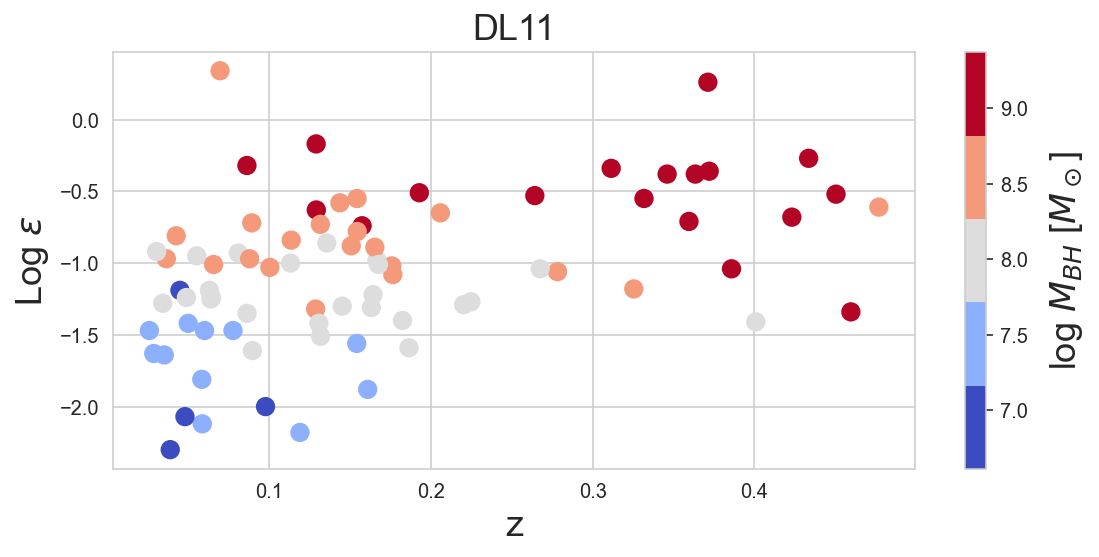

In [185]:
cmap = cm.get_cmap('coolwarm',5)
fig,ax= plt.subplots(figsize=(8, 4))
points = plt.scatter(x=D11_standard.z, y=np.log10(D11_standard.epsilon_obsv), c=D11_standard.log_bh,s=75, 
                     cmap=cmap,label='$DL_{11}$')
cbar=plt.colorbar(points)
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
# plt.ylim(0,0.5)
# plt.legend(loc='best')
plt.xlabel('z',size=18)
plt.title('DL11',size=18)
plt.ylabel('Log $\epsilon$',size=18)
plt.tight_layout()
sns.set_style("whitegrid")
plt.savefig('79_18_standard_log_D11_epsilon_vs_z_MBH_colored.pdf',dpi=600)
# plt.yscale('log')
plt.show()

-----

## Mixing DL11 and Vol and fluxed

In [188]:
vol_standard_nonan

,z,log_bh,epsopt
0,5.8440,8.000000,0.010598
1,5.8540,8.954243,0.041062
2,5.9030,9.204120,0.061637
3,6.0170,9.230449,0.077563
4,6.0180,9.462398,0.135307
...,...,...,...
71,6.9018,9.296665,0.140975
72,7.1000,9.208819,0.040066
73,6.9000,9.322219,0.156498
74,6.7000,9.031291,0.054506


In [190]:
qn_dl11_vol=pd.concat([vol_standard_nonan,D11_standard],ignore_index=False)
qn_dl11_vol_cols=qn_dl11_vol.columns.tolist()
qn_dl11_vol_cols=['z','epsopt','log_bh']
qn_dl11_vol=qn_dl11_vol[qn_dl11_vol_cols]
qn_dl11_vol=qn_dl11_vol.dropna()
qn_dl11_vol=qn_dl11_vol.reset_index(drop=True).drop_duplicates()
qn_dl11_vol

,z,epsopt,log_bh
0,5.8440,0.010598,8.000000
1,5.8540,0.041062,8.954243
2,5.9030,0.061637,9.204120
3,6.0170,0.077563,9.230449
4,6.0180,0.135307,9.462398
...,...,...,...
150,0.0697,2.187762,8.601000
151,0.0657,0.097724,8.308000
152,0.3255,0.066069,8.816000
153,0.0426,0.154882,8.320000


The peaks of D11 + QN =[2.675]
y_cal = -0.01621 * x**2 + 0.08671 * x +  -1.07704 


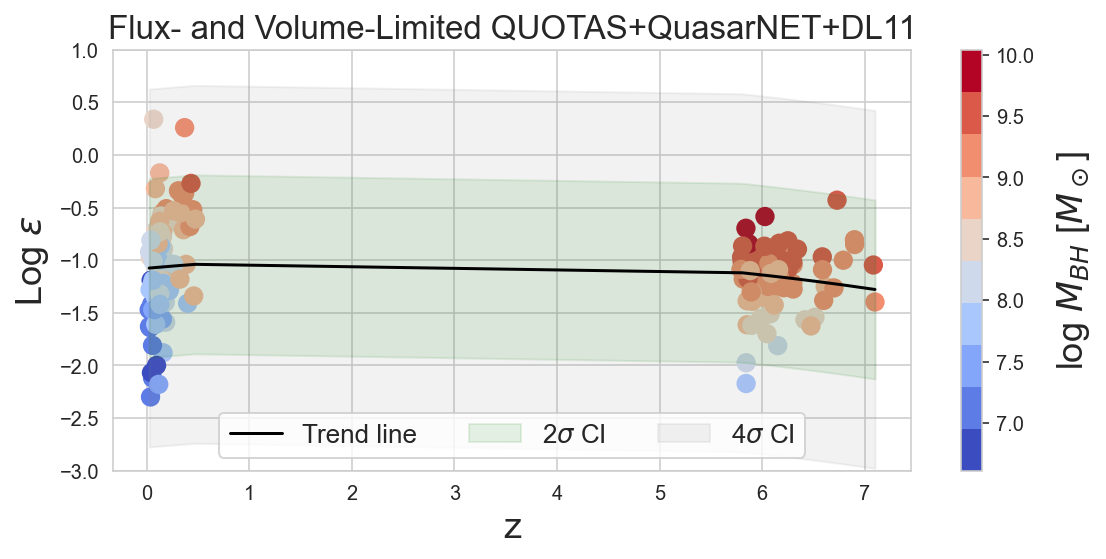

In [191]:
cmap = cm.get_cmap('coolwarm',10)
fig,ax= plt.subplots(figsize=(8, 4))
fit_Qnet_dict = {}
points = plt.scatter(x=qn_dl11_vol.z, y=np.log10(qn_dl11_vol.epsopt), c=qn_dl11_vol.log_bh,s=75, 
                     cmap=cmap)
qn_dl11_vol_sort=qn_dl11_vol.sort_values('z')
x_flvl = qn_dl11_vol_sort['z'].values
y_flvl = np.log10(qn_dl11_vol_sort['epsopt']).values

def obj(x, a, b,c):
    return a * x**2 + b*x+c

guess = [min(y_flvl), min(y_flvl), min(y_flvl)]
parameters_flvl, _ = curve_fit(obj, x_flvl, y_flvl)

fit_D_flvl = parameters_flvl[0]
fit_E_flvl = parameters_flvl[1]
fit_F_flvl = parameters_flvl[2]

fit_obj_flvl = obj(x_flvl, fit_D_flvl, fit_E_flvl,fit_F_flvl)
def fit_Qnet(x):
    return fit_D_flvl * x**2 + fit_E_flvl * x +  fit_F_flvl
fit_Qnet_dict[0] = fit_Qnet
x_q=np.arange(0,8,0.001)
peaks, _ = sig.find_peaks(fit_Qnet_dict[0](x_q))
print("The peaks of D11 + QN ={}".format(x_q[peaks]))
print('y_cal = %.5f * x**2 + %.5f * x +  %.5f ' % (fit_D_flvl, fit_E_flvl,fit_F_flvl))


residuals_flvl = y_flvl - fit_obj_flvl
sigma2_flvl = 2 * np.std(residuals_flvl)
sigma4_flvl= 4 * np.std(residuals_flvl)
plt.fill_between(x_flvl, fit_obj_flvl - sigma2_flvl, fit_obj_flvl + sigma2_flvl,color='g', alpha=0.1,label='2$\sigma$ CI')
plt.fill_between(x_flvl, fit_obj_flvl - sigma4_flvl, fit_obj_flvl + sigma4_flvl,color='grey', alpha=0.1,label='4$\sigma$ CI')
# plt.axhspan(0.0, -0.5, alpha=0.1,hatch='/',color='r',xmin=0.044,xmax=1-0.045)

plt.plot(x_flvl, fit_obj_flvl, 'black',label='Trend line')
cbar=plt.colorbar(points)
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
plt.xlabel('z',size=18)
plt.ylim(-3,1)
plt.title('Flux- and Volume-Limited QUOTAS+QuasarNET+DL11',size=16.5)
plt.ylabel('Log $\epsilon$',size=18)
plt.tight_layout()
# plt.yscale('log')
plt.legend(ncol=3,loc='lower center',fontsize=13)
plt.savefig('76_18_log_vol_epsilon_vs_z_11_qn_novol_fit.pdf',dpi=600)
plt.show()

In [192]:
round(sigma2_flvl,4),round(sigma4_flvl,4)

(0.8505, 1.7011)

# Plotting Lmin and Lmax

## Volume and Flux limited standard 

In [193]:
vol_standard

,Unnamed: 0,name,z,log_bh,log_lbol,log_edd_ratio,m_app_bol,m_app_lim,M_bol,M_abs_lim,dist,l_3000,l_1350,l_1700,l_5100,eps_5100,eps_3000,eps_1350,eps_1700,L_L,L_max_col,eps_min_col,epsopt_3000,epsopt_1350,epsopt_1700,L_min_col,eps_min_total
0,0,SDSS J0005-0006,5.8440,8.000000,46.670246,0.556303,20.794011,24.224476,-27.930465,-27.024726,55577.014461,45.958439,NaN,NaN,NaN,NaN,0.010598,NaN,NaN,0.640560,NaN,0.010598,0.010598,NaN,NaN,45.958439,0.010598
1,1,SDSS J1411+1217,5.8540,8.954243,47.182129,0.113943,19.518620,24.228794,-29.210173,-27.029044,55687.626897,46.470322,NaN,NaN,NaN,NaN,0.041062,NaN,NaN,0.640564,NaN,0.041062,0.041062,NaN,NaN,46.470322,0.041062
2,3,SDSS J1411+1217,5.9030,9.204120,47.272306,-0.045757,19.314224,24.249838,-29.435615,-27.050089,56229.943014,46.560499,NaN,NaN,NaN,NaN,0.061637,NaN,NaN,0.640582,NaN,0.061637,0.061637,NaN,NaN,46.560499,0.061637
3,5,SDSS J1306+0356,6.0170,9.230449,47.122544,-0.221849,19.736891,24.298100,-29.061209,-27.098350,57493.657912,46.410736,NaN,NaN,NaN,NaN,0.077563,NaN,NaN,0.640622,NaN,0.077563,0.077563,NaN,NaN,46.410736,0.077563
4,7,SDSS J1306+0356,6.0180,9.462398,47.053463,-0.522879,19.910012,24.298519,-28.888507,-27.098769,57504.755357,46.341655,NaN,NaN,NaN,NaN,0.135307,NaN,NaN,0.640622,NaN,0.135307,0.135307,NaN,NaN,46.341655,0.135307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,88,VIKING J234833.34-305410.0,6.9018,9.296665,46.633468,-0.769551,21.304462,24.642983,-27.838521,-27.443233,67390.167868,45.954243,NaN,NaN,NaN,NaN,0.140975,NaN,NaN,0.640888,NaN,0.140975,0.140975,NaN,NaN,45.954243,0.140975
72,89,ULAS J1120+0641,7.1000,9.208819,47.174205,-0.318759,20.023519,24.713882,-29.190363,-27.514132,69626.798140,46.462398,46.623249,NaN,NaN,NaN,0.069832,0.040066,NaN,0.640939,NaN,0.040066,0.069832,0.040066,NaN,46.462398,0.040066
73,90,VIKING J234833.34-305410.0,6.9000,9.322219,46.684935,-0.744727,21.175141,24.642329,-27.967188,-27.442579,67369.886603,45.973128,NaN,NaN,NaN,NaN,0.156498,NaN,NaN,0.640888,NaN,0.156498,0.156498,NaN,NaN,45.973128,0.156498
74,91,VIKING J010953.13-304726.3,6.7000,9.031291,46.741191,-0.619789,20.960745,24.568572,-28.107828,-27.368822,65120.004719,46.029384,46.143015,NaN,NaN,NaN,0.080704,0.054506,NaN,0.640833,NaN,0.054506,0.080704,0.054506,NaN,46.029384,0.054506


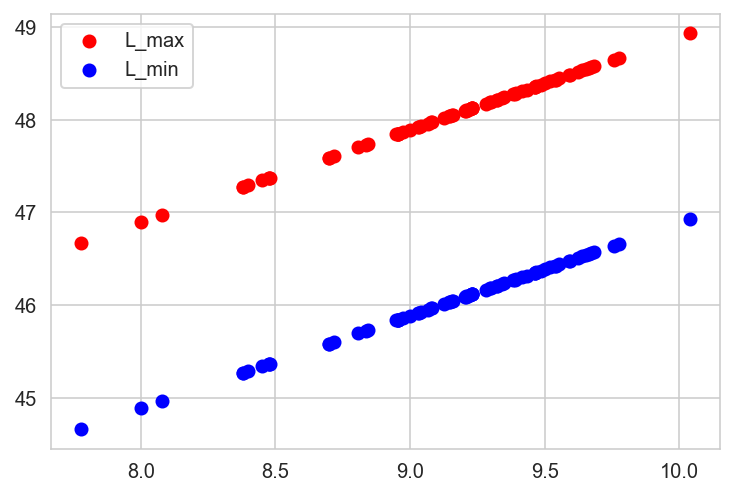

In [194]:
vol_standard=vol_standard.reset_index(drop=True)
def Leddar(Lbol,M):
    return Lbol/(1.3e+38*M)
Ledd_cal=[];
for i in range(len(vol_standard)):
    Ledd_cal.append(Leddar(10**vol_standard['log_lbol'][i],10**vol_standard['log_bh'][i]))
lbolmax=[];lbolmin=[]
for i in range(len(vol_standard)):
    lbolmax.append(np.log10((max(Ledd_cal)*1.3e+38*(10**vol_standard['log_bh'][i]))))
    lbolmin.append(np.log10((min(Ledd_cal)*1.3e+38*(10**vol_standard['log_bh'][i]))))
vol_standard['log_lbol_max']=lbolmax
vol_standard['log_lbol_min']=lbolmin
vol_standard['epsopt_3000_lim_max']=(Epsilonopt(10**(vol_standard['log_lbol_max']),
                                               10**(vol_standard['log_bh']),10**(vol_standard['l_3000'])))
vol_standard['epsopt_1350_lim_max']=(Epsilonopt(10**(vol_standard['log_lbol_max']),
                                               10**(vol_standard['log_bh']),10**(vol_standard['l_1350'])))
vol_standard['epsopt_1700_lim_max']=(Epsilonopt(10**(vol_standard['log_lbol_max']),
                                               10**(vol_standard['log_bh']),10**(vol_standard['l_1700'])))

vol_standard['epsopt_3000_lim_min']=(Epsilonopt(10**(vol_standard['log_lbol_min']),
                                               10**(vol_standard['log_bh']),10**(vol_standard['l_3000'])))
vol_standard['epsopt_1350_lim_min']=(Epsilonopt(10**(vol_standard['log_lbol_min']),
                                               10**(vol_standard['log_bh']),10**(vol_standard['l_1350'])))
vol_standard['epsopt_1700_lim_min']=(Epsilonopt(10**(vol_standard['log_lbol_min']),
                                               10**(vol_standard['log_bh']),10**(vol_standard['l_1700'])))
plt.scatter((vol_standard['log_bh']),lbolmax,c='r',label='L_max')
plt.scatter((vol_standard['log_bh']),lbolmin,c='b',label='L_min')
plt.legend()
plt.show()

In [201]:
# max_columns = vol_standard[[ 'l_3000','l_1700','l_1350']].idxmax(axis=1)
eps_min_columns = vol_standard[['epsopt_3000','epsopt_1700','epsopt_1350']].idxmin(axis=1)
epsmin_min_columns = vol_standard[[ 'epsopt_3000_lim_min',
                           'epsopt_1350_lim_min','epsopt_1700_lim_min']].idxmin(axis=1)
epsmax_min_columns = vol_standard[['epsopt_3000_lim_max',
                           'epsopt_1350_lim_max','epsopt_1700_lim_max']].idxmin(axis=1)
vol_standard.fillna(np.inf, inplace=True)
vol_max,vol_eps_min,vol_epsmin_min,vol_epsmax_min = np.empty(len(vol_standard.index), 
                                                         dtype="O"),np.empty(len(vol_standard.index), 
                                                         dtype="O"),np.empty(len(vol_standard.index), 
                                                         dtype="O"),np.empty(len(vol_standard.index), dtype="O")
for i, (r, c) in enumerate(zip(vol_standard.index, max_columns)):
    vol_max[i] = vol_standard._get_value(r, c)
for i, (r, c) in enumerate(zip(vol_standard.index, eps_min_columns)):
    vol_eps_min[i] = vol_standard._get_value(r, c)
for i, (r, c) in enumerate(zip(vol_standard.index, epsmin_min_columns)):
    vol_epsmin_min[i] = vol_standard._get_value(r, c)
for i, (r, c) in enumerate(zip(vol_standard.index, epsmax_min_columns)):
    vol_epsmax_min[i] = vol_standard._get_value(r, c)
vol_standard['L_max_col'] = vol_max
vol_standard['eps_col'] = vol_eps_min
vol_standard['epsopt_min'] = vol_epsmin_min
vol_standard['epsopt_max'] = vol_epsmax_min
vol_standard=vol_standard.drop_duplicates()
vol_standard

,Unnamed: 0,name,z,log_bh,log_lbol,log_edd_ratio,m_app_bol,m_app_lim,M_bol,M_abs_lim,dist,l_3000,l_1350,l_1700,l_5100,eps_5100,eps_3000,eps_1350,eps_1700,L_L,L_max_col,eps_min_col,epsopt_3000,epsopt_1350,epsopt_1700,L_min_col,eps_min_total,log_lbol_max,log_lbol_min,epsopt_3000_lim_max,epsopt_1350_lim_max,epsopt_1700_lim_max,epsopt_3000_lim_min,epsopt_1350_lim_min,epsopt_1700_lim_min,eps_col,epsopt_min,epsopt_max
0,0,SDSS J0005-0006,5.8440,8.000000,46.670246,0.556303,20.794011,24.224476,-27.930465,-27.024726,55577.014461,45.958439,inf,inf,inf,inf,0.010598,inf,inf,0.640560,inf,0.010598,0.010598,inf,inf,45.958439,0.010598,46.892095,44.884205,0.017573,inf,inf,0.000181,inf,inf,0.010598,0.000181,0.017573
1,1,SDSS J1411+1217,5.8540,8.954243,47.182129,0.113943,19.518620,24.228794,-29.210173,-27.029044,55687.626897,46.470322,inf,inf,inf,inf,0.041062,inf,inf,0.640564,inf,0.041062,0.041062,inf,inf,46.470322,0.041062,47.846337,45.838447,0.186641,inf,inf,0.001920,inf,inf,0.041062,0.00192,0.186641
2,3,SDSS J1411+1217,5.9030,9.204120,47.272306,-0.045757,19.314224,24.249838,-29.435615,-27.050089,56229.943014,46.560499,inf,inf,inf,inf,0.061637,inf,inf,0.640582,inf,0.061637,0.061637,inf,inf,46.560499,0.061637,48.096215,46.088325,0.403192,inf,inf,0.004147,inf,inf,0.061637,0.004147,0.403192
3,5,SDSS J1306+0356,6.0170,9.230449,47.122544,-0.221849,19.736891,24.298100,-29.061209,-27.098350,57493.657912,46.410736,inf,inf,inf,inf,0.077563,inf,inf,0.640622,inf,0.077563,0.077563,inf,inf,46.410736,0.077563,48.122544,46.114654,0.757973,inf,inf,0.007795,inf,inf,0.077563,0.007795,0.757973
4,7,SDSS J1306+0356,6.0180,9.462398,47.053463,-0.522879,19.910012,24.298519,-28.888507,-27.098769,57504.755357,46.341655,inf,inf,inf,inf,0.135307,inf,inf,0.640622,inf,0.135307,0.135307,inf,inf,46.341655,0.135307,48.354493,46.346603,2.626270,inf,inf,0.027010,inf,inf,0.135307,0.02701,2.62627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,88,VIKING J234833.34-305410.0,6.9018,9.296665,46.633468,-0.769551,21.304462,24.642983,-27.838521,-27.443233,67390.167868,45.954243,inf,inf,inf,inf,0.140975,inf,inf,0.640888,45.954243,0.140975,0.140975,inf,inf,45.954243,0.140975,48.188760,46.180870,4.885185,inf,inf,0.050242,inf,inf,0.140975,0.050242,4.885185
72,89,ULAS J1120+0641,7.1000,9.208819,47.174205,-0.318759,20.023519,24.713882,-29.190363,-27.514132,69626.798140,46.462398,46.623249,inf,inf,inf,0.069832,0.040066,inf,0.640939,46.462398,0.040066,0.069832,0.040066,inf,46.462398,0.040066,48.100913,46.093024,0.577426,0.331299,inf,0.005939,0.003407,inf,0.040066,0.003407,0.331299
73,90,VIKING J234833.34-305410.0,6.9000,9.322219,46.684935,-0.744727,21.175141,24.642329,-27.967188,-27.442579,67369.886603,45.973128,inf,inf,inf,inf,0.156498,inf,inf,0.640888,inf,0.156498,0.156498,inf,inf,45.973128,0.156498,48.214314,46.206424,5.112045,inf,inf,0.052576,inf,inf,0.156498,0.052576,5.112045
74,91,VIKING J010953.13-304726.3,6.7000,9.031291,46.741191,-0.619789,20.960745,24.568572,-28.107828,-27.368822,65120.004719,46.029384,46.143015,inf,inf,inf,0.080704,0.054506,inf,0.640833,inf,0.054506,0.080704,0.054506,inf,46.029384,0.054506,47.923386,45.915496,1.194719,0.806899,inf,0.012287,0.008299,inf,0.054506,0.008299,0.806899


In [202]:
vol_standard = vol_standard.replace([np.inf], np.nan)
vol_standard_lambda=pd.DataFrame({'z':vol_standard['z'],'log_bh':vol_standard['log_bh'],
                          'epsopt':vol_standard['eps_col'],'epsopt_max':vol_standard['epsopt_max']
                         , 'epsopt_min':vol_standard['epsopt_min']})
# vol_standard_lambda=pd.concat([vol_standard_lambda,D11_standard],ignore_index=False)
vol_standard_lambda=vol_standard_lambda[(vol_standard_lambda['epsopt'].notna())].reset_index(drop=True)
vol_standard_lambda=pd.DataFrame({'z':vol_standard_lambda['z'],'log_bh':vol_standard_lambda['log_bh'],
                          'epsopt':vol_standard_lambda['epsopt'],'epsopt_max':vol_standard_lambda['epsopt_max']
                         ,'epsopt_min':vol_standard_lambda['epsopt_min']})
vol_standard_lambda=vol_standard_lambda[(vol_standard_lambda['epsopt'].notna())]
vol_standard_lambda=vol_standard_lambda.sort_values('log_bh').reset_index(drop=True).drop_duplicates().dropna()
vol_standard_lambda

,z,log_bh,epsopt,epsopt_max,epsopt_min
0,5.844000,7.778151,0.006726,0.006726,0.000069
1,5.844000,8.000000,0.010598,0.017573,0.000181
2,6.152000,8.079181,0.015404,0.046147,0.000475
3,5.983000,8.380211,0.027845,0.157870,0.001624
4,6.047000,8.380211,0.020046,0.060054,0.000618
...,...,...,...,...,...
71,6.730000,9.672098,0.372049,36.175215,0.372049
72,5.818413,9.683876,0.078550,1.452891,0.014942
73,5.842035,9.757015,0.201235,5.117148,0.052628
74,5.869620,9.777116,0.143489,4.137965,0.042557


y_cal = 1.310524052380001*x+ -12.078857760441803 


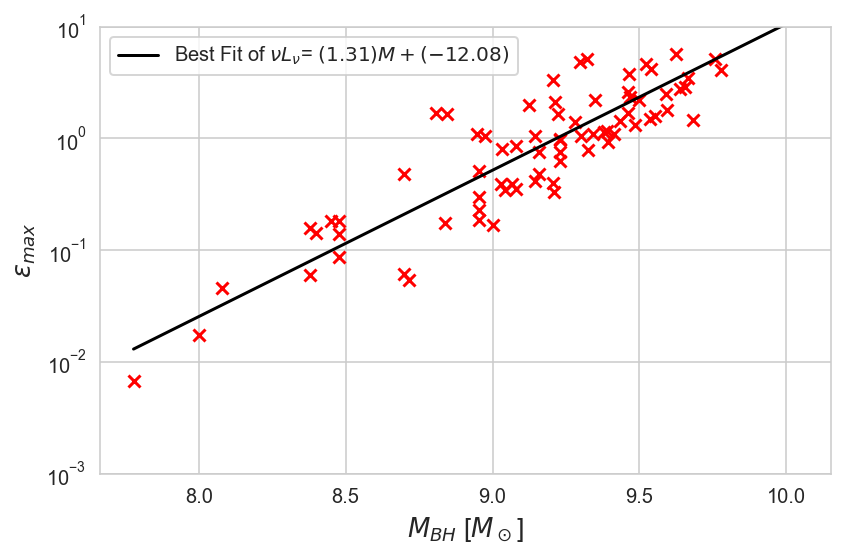

y_cal = 1.310524042016619*x+ -14.066668725905588 


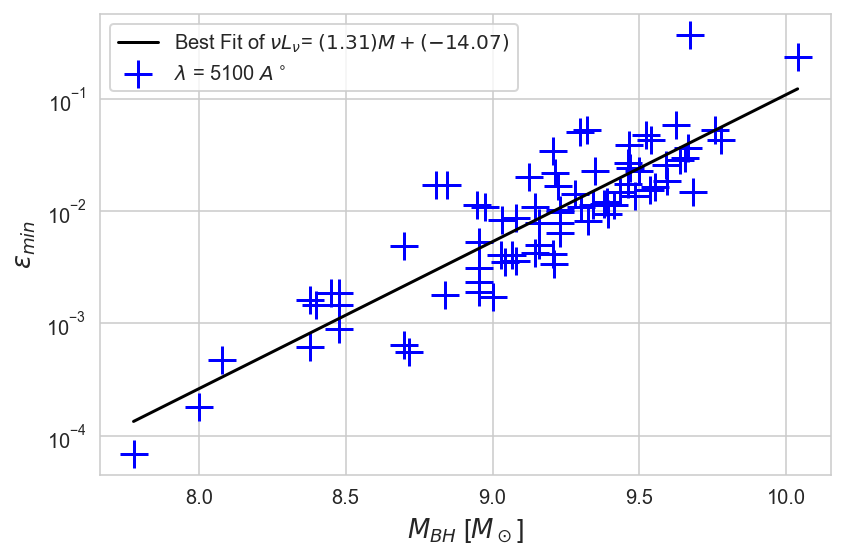

In [203]:
dattotsort3=vol_standard_lambda.sort_values('log_bh')
dattotsort3=dattotsort3.reset_index(drop=True)

x513= dattotsort3['log_bh'].values
y513= np.log10(dattotsort3['epsopt_max']).values
def obj(x, a,b):
    return a*(x)+b

# guess = [min(y513),min(y513)]
parameters513, _ = curve_fit(obj, x513, y513)
fit_D513 = parameters513[0]
fit_E513 = parameters513[1]


fit_obj513 = obj(x513, fit_D513,fit_E513)

print('y_cal = %.15f*x+ %.15f ' % (fit_D513,fit_E513))

plt.plot(x513, 10**fit_obj513,'black',
        label=r'Best Fit of $\nu L_\nu$= $({})M+({})$'.format(round(fit_D513,2), round(fit_E513,2)))
plt.scatter(vol_standard_lambda['log_bh'],vol_standard_lambda['epsopt_max'],c='r',marker='x')
plt.ylabel('$\epsilon_{max}$',size=13)
plt.xlabel('$M_{BH}$ [$M_\odot$]',size=13)
plt.yscale('log')
plt.ylim(0.001,10)
plt.legend()
plt.tight_layout()
plt.show()
################################################################################################
dattotsort4=vol_standard_lambda.sort_values('log_bh')
dattotsort4=dattotsort4.reset_index(drop=True)
x514 = dattotsort4['log_bh'].values
y514 = np.log10(dattotsort4['epsopt_min']).values

def obj(x, a,b):
    return a*(x)+b

# guess = [min(y51),min(y51),min(y51)]
parameters514, _ = curve_fit(obj, x514, y514)
fit_D514 = parameters514[0]
fit_E514 = parameters514[1]

fit_obj514 = obj(x514, fit_D514,fit_E514)

print('y_cal = %.15f*x+ %.15f ' % (fit_D514,fit_E514))

plt.plot(x514, 10**fit_obj514,'black',
        label=r'Best Fit of $\nu L_\nu$= $({})M+({})$'.format(round(fit_D514,2), round(fit_E514,2)))
plt.scatter(vol_standard_lambda['log_bh'],vol_standard_lambda['epsopt_min'],c='b',marker='+',s=200,label='$\lambda$ = 5100 $A^\circ$')
plt.ylabel('$\epsilon_{min}$',size=13)
plt.xlabel('$M_{BH}$ [$M_\odot$]',size=13)
plt.yscale('log')
# plt.ylim(0.0001,10)
plt.legend()
plt.tight_layout()
plt.show()

In [206]:
def QN_VOL_min(x):
    return fit_D514*x + fit_E514
def QN_VOL_max(x):
    return fit_D513*x + fit_E513

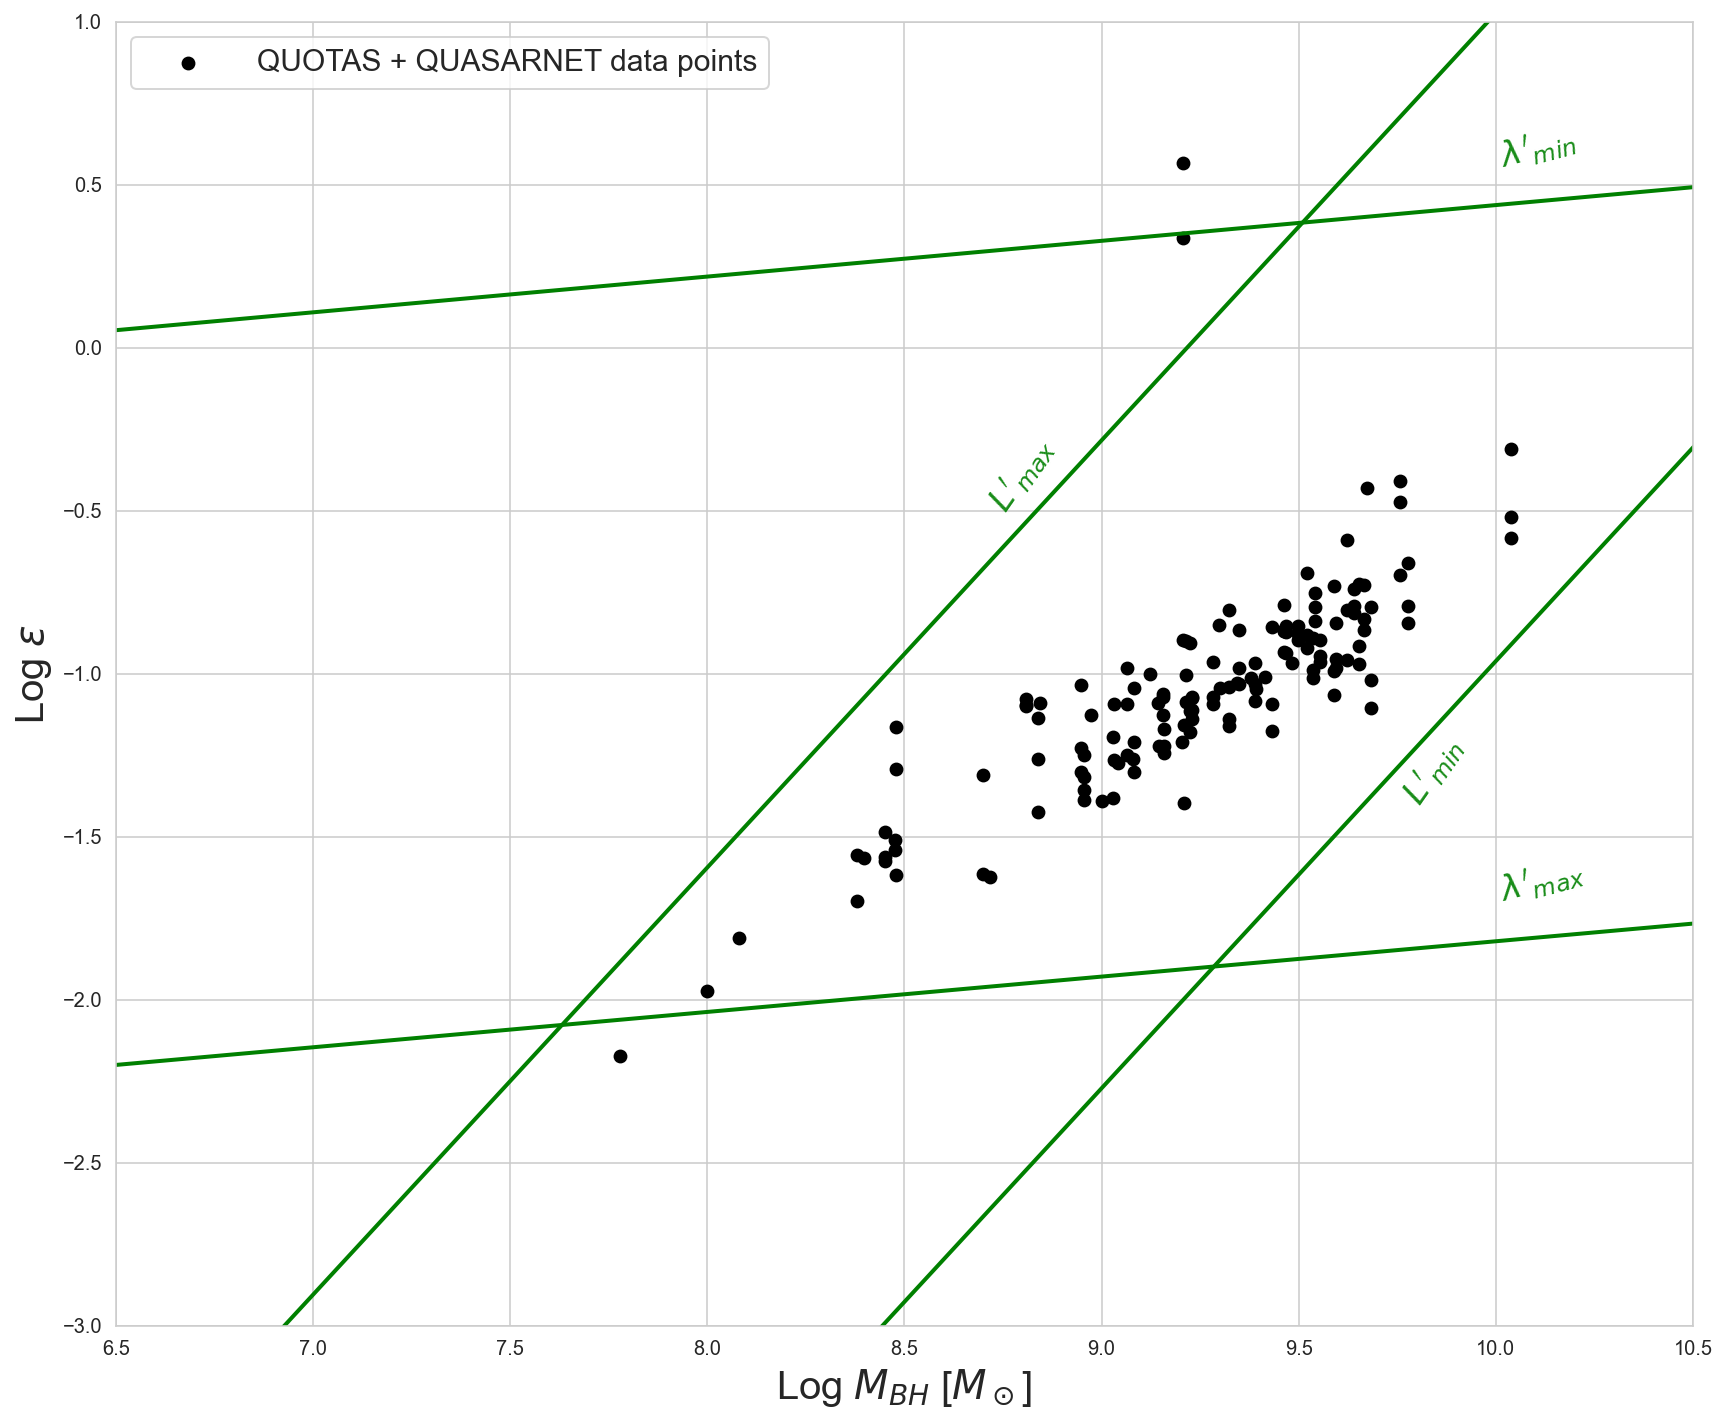

In [208]:
fig,ax= plt.subplots(figsize=(12, 10))
x_lambda = np.linspace(6,12,100)
# vol_11_qn_sort=vol_11_qn_sort.sort_values('log_bh')
plt.scatter(vol_standard['log_bh'],np.log10(vol_standard['epsopt_3000']),c='k',s=35,label='QUOTAS + QUASARNET data points')
# plt.scatter(vol_standard['log_bh'],np.log10(vol_standard['epsopt_5100']),c='k',s=35)
plt.scatter(vol_standard['log_bh'],np.log10(vol_standard['epsopt_1350']),c='k',s=35)
plt.scatter(vol_standard['log_bh'],np.log10(vol_standard['epsopt_1700']),c='k',s=35)
plt.plot(x_lambda, QN_VOL_max(x_lambda),
         c='g',linestyle='solid',linewidth=2)
plt.plot(x_lambda, QN_VOL_min(x_lambda),
         c='g',linestyle='solid',linewidth=2)
plt.plot(np.linspace(7.808362-3,10.828106+1,100),np.linspace(-0.131725,0.638218,100),
         c='g',linestyle='solid',linewidth=2)
plt.plot(np.linspace(7.788037-3,10.804878+1,100),np.linspace(-2.385899,-1.625231,100),
         c='g',linestyle='solid',linewidth=2)
plt.ylim(-3,1)
plt.ylabel('Log $\epsilon$',size=20)
plt.xlabel('Log $M_{BH}$ [$M_\odot$]',size=20)
plt.legend(loc='best',fontsize=15,handlelength=3)
plt.tight_layout()

plt.text(10, -1.7, "$\lambda'_{max}$", rotation=15,
         fontsize = 17, color = 'g',alpha=0.9)
plt.text(10, 0.55, "$\lambda'_{min}$", rotation=15,
         fontsize = 17, color = 'g',alpha=0.9)

plt.text(8.7, -0.5, "$L'_{max}$", rotation=55,
         fontsize = 17, color = 'g',alpha=0.9)
plt.text(9.75, -1.4, "$L'_{min}$", rotation=55,
         fontsize = 17, color = 'g',alpha=0.9)


plt.xlim(6.5,10.5)

plt.savefig('76_standard_vol_flux_-3_1_qn_epsilon_vs_M_lambda_L_min_max_fits.pdf',dpi=600)
plt.show()

## For D11 Lmin Lmax

In [209]:
D11_standard

,Object,z,log_bh,log_edd_ratio,logLoptb,LogMdot,logLbolb,logeps,epsilon_obsv,epsopt,epsopt_lambda
0,0003 + 158,0.4505,9.055,-0.358,45.87,0.79,46.92,-0.52,0.301995,0.301995,0.220847
1,0003 + 199,0.0260,7.220,-0.342,43.91,-0.06,45.13,-1.47,0.033884,0.033884,0.075656
2,0007 + 106,0.0893,8.561,-0.972,44.55,-0.42,45.52,-0.72,0.190546,0.190546,0.315087
3,0026 + 129,0.1452,7.833,0.053,44.99,0.80,46.15,-1.30,0.050119,0.050119,0.065194
4,0043 + 039,0.3859,8.952,-0.648,45.47,0.36,45.98,-1.04,0.091201,0.091201,0.083526
...,...,...,...,...,...,...,...,...,...,...,...
76,2209 + 184,0.0697,8.601,-1.353,44.11,-0.98,46.02,0.34,2.187762,2.187762,4.886867
77,2214 + 139,0.0657,8.308,-1.027,44.36,-0.50,45.15,-1.01,0.097724,0.097724,0.155582
78,2251 + 113,0.3255,8.816,-0.363,45.60,0.66,46.13,-1.18,0.066069,0.066069,0.056791
79,2304 + 042,0.0426,8.320,-1.633,43.67,-1.35,44.49,-0.81,0.154882,0.154882,0.383920


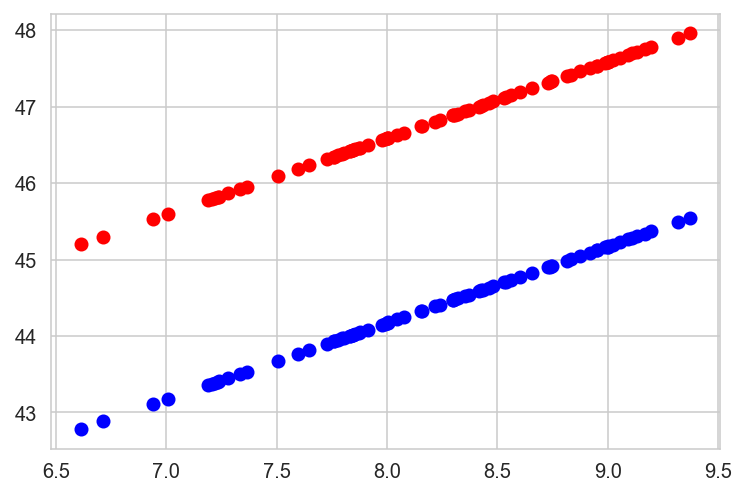

In [210]:
D11_standard=D11_standard.reset_index(drop=True)
def Leddar(Lbol,M):
    return Lbol/(1.3e+38*M)
Ledd_cal_11=[];
for i in range(len(D11_standard)):
    Ledd_cal_11.append(Leddar(10**D11_standard['logLbolb'][i],10**D11_standard['log_bh'][i]))
lbolmax_11=[];lbolmin_11=[]
for i in range(len(D11_standard)):
    lbolmax_11.append(np.log10((max(Ledd_cal_11)*1.3e+38*(10**D11_standard['log_bh'][i]))))
    lbolmin_11.append(np.log10((min(Ledd_cal_11)*1.3e+38*(10**D11_standard['log_bh'][i]))))
D11_standard['log_lbol_max']=lbolmax_11
D11_standard['log_lbol_min']=lbolmin_11
plt.scatter((D11_standard['log_bh']),lbolmax_11,c='r')
plt.scatter((D11_standard['log_bh']),lbolmin_11,c='b')

In [211]:
eps_D11_max=[];eps_D11_min=[];
for i in range(len(D11_standard)):
    eps_D11_max.append(Epsilonopt(10**D11_standard['log_lbol_max'][i],
                               10**D11_standard['log_bh'][i],10**D11_standard['logLoptb'][i]))
    eps_D11_min.append(Epsilonopt(10**D11_standard['log_lbol_min'][i],
                               10**D11_standard['log_bh'][i],10**D11_standard['logLoptb'][i]))
D11_standard['epsopt_max']=eps_D11_max
D11_standard['epsopt_min']=eps_D11_min

In [213]:
D11_standard_lambda=pd.DataFrame({'z':D11_standard['z'],'log_bh':D11_standard['log_bh'],
                          'epsopt':D11_standard['epsopt']
                                  ,'epsopt_max':D11_standard['epsopt_max']
                         , 'epsopt_min':D11_standard['epsopt_min']
                                 })
D11_standard_lambda=D11_standard_lambda[(D11_standard_lambda['epsopt'].notna())].reset_index(drop=True)
D11_standard_lambda_st=D11_standard_lambda.sort_values('log_bh').reset_index(drop=True)
D11_standard_lambda_st

,z,log_bh,epsopt,epsopt_max,epsopt_min
0,0.0480,6.614,0.008511,0.052942,0.000215
1,0.0978,6.713,0.010000,0.016593,0.000067
2,0.0449,6.940,0.064565,0.352112,0.001428
3,0.0389,7.010,0.005012,0.147326,0.000598
4,0.0584,7.190,0.015488,0.172457,0.000700
...,...,...,...,...,...
74,0.4232,9.132,0.208930,7.288540,0.029567
75,0.3713,9.168,1.819701,7.166722,0.029072
76,0.3721,9.198,0.436516,4.536496,0.018403
77,0.3635,9.317,0.416869,10.726068,0.043511


y_cal = 0.820958087600112*x+ -6.542701277873032 


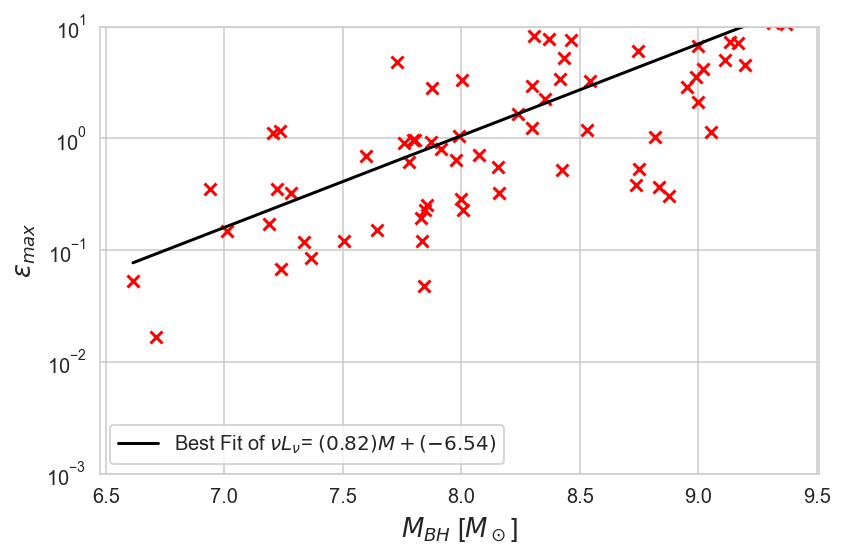

y_cal = 0.820958105600418*x+ -8.934541425588549 


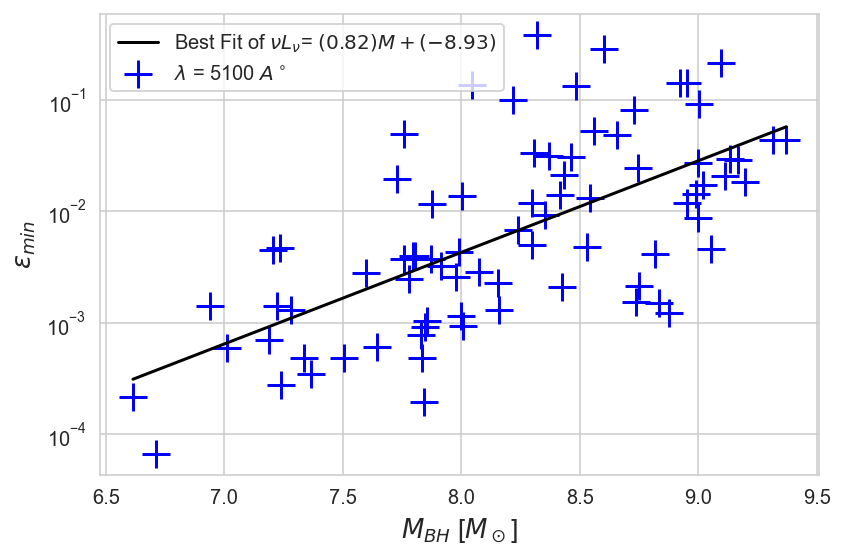

In [214]:
dattotsort3=D11_standard_lambda.sort_values('log_bh')
dattotsort3=dattotsort3.reset_index(drop=True)

x513= dattotsort3['log_bh'].values
y513= np.log10(dattotsort3['epsopt_max']).values
def obj(x, a,b):
    return a*(x)+b

guess = [min(y513),min(y513)]
parameters513, _ = curve_fit(obj, x513, y513,guess)
fit_D513 = parameters513[0]
fit_E513 = parameters513[1]


fit_obj513 = obj(x513, fit_D513,fit_E513)

print('y_cal = %.15f*x+ %.15f ' % (fit_D513,fit_E513))

plt.plot(x513, 10**fit_obj513,'black',
        label=r'Best Fit of $\nu L_\nu$= $({})M+({})$'.format(round(fit_D513,2), round(fit_E513,2)))
plt.scatter(D11_standard_lambda['log_bh'],D11_standard_lambda['epsopt_max'],c='r',marker='x')

plt.ylabel('$\epsilon_{max}$',size=13)
plt.xlabel('$M_{BH}$ [$M_\odot$]',size=13)
plt.yscale('log')
plt.ylim(0.001,10)
plt.legend()
plt.tight_layout()
plt.show()
################################################################################################
dattotsort4=D11_standard_lambda.sort_values('log_bh')
dattotsort4=dattotsort4.reset_index(drop=True)
x514 = dattotsort4['log_bh'].values
y514 = np.log10(dattotsort4['epsopt_min']).values

def obj(x, a,b):
    return a*(x)+b

parameters514, _ = curve_fit(obj, x514, y514)
fit_D514 = parameters514[0]
fit_E514 = parameters514[1]
# fit_F513 = parameters513[2]
# fit_G512 = parameters512[3]

fit_obj514 = obj(x514, fit_D514,fit_E514)

print('y_cal = %.15f*x+ %.15f ' % (fit_D514,fit_E514))

plt.plot(x514, 10**fit_obj514,'black',
        label=r'Best Fit of $\nu L_\nu$= $({})M+({})$'.format(round(fit_D514,2), round(fit_E514,2)))
plt.scatter(D11_standard_lambda['log_bh'],D11_standard_lambda['epsopt_min'],c='b',
            marker='+',s=200,label='$\lambda$ = 5100 $A^\circ$')

plt.ylabel('$\epsilon_{min}$',size=13)
plt.xlabel('$M_{BH}$ [$M_\odot$]',size=13)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [215]:
def d11_l_min(x):
    return fit_D514*x + fit_E514
def d11_l_max(x):
    return fit_D513*x + fit_E513

In [89]:
# def d11_l_max(x):
#     return 0.808349547786876*x -6.455005883240125 
# def d11_l_min(x):
#     return 0.808349541353790*x -8.846845830561760 

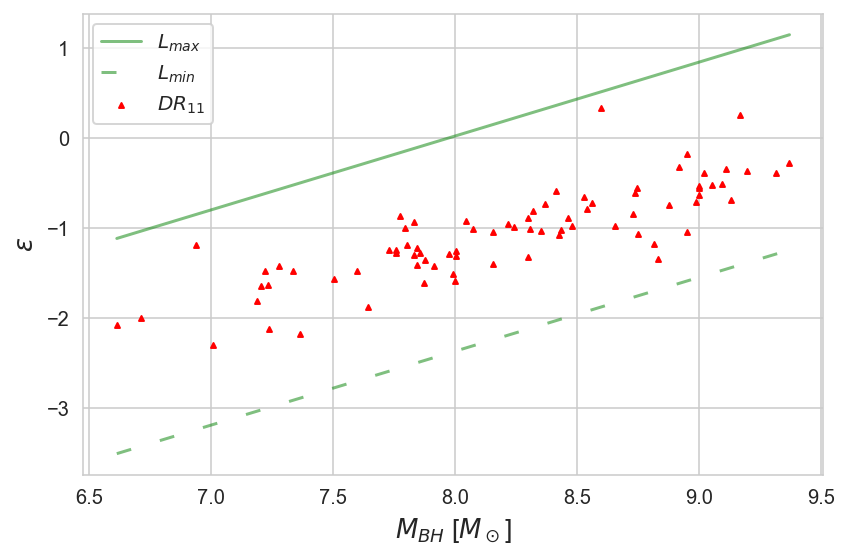

In [216]:
D11_standard_lambda_sort=D11_standard_lambda.sort_values('log_bh')
plt.scatter(D11_standard['log_bh'],np.log10(D11_standard['epsopt']),c='r',s=6, label='$DR_{11}$',marker='^')
plt.plot(D11_standard_lambda_sort['log_bh'], d11_l_max(D11_standard_lambda_sort['log_bh']),
         label='$L_{max}$',c='g',linestyle='solid',alpha=0.5)
plt.plot(D11_standard_lambda_sort['log_bh'], d11_l_min(D11_standard_lambda_sort['log_bh']),
         label='$L_{min}$',c='g',linestyle='dashed',dashes=(5,10,5,10),alpha=0.5)
plt.ylabel('$\epsilon$',size=13)
plt.xlabel('$M_{BH}$ [$M_\odot$]',size=13)
plt.legend()
plt.tight_layout()
plt.show()

# Total:

In [217]:
total_lambda=pd.concat([vol_standard_lambda,D11_standard_lambda],ignore_index=True)
total_lambda=total_lambda.drop_duplicates()

In [218]:
total_lambda.reset_index(drop=True) #from before

,z,log_bh,epsopt,epsopt_max,epsopt_min
0,5.8440,7.778151,0.006726,0.006726,0.000069
1,5.8440,8.000000,0.010598,0.017573,0.000181
2,6.1520,8.079181,0.015404,0.046147,0.000475
3,5.9830,8.380211,0.027845,0.157870,0.001624
4,6.0470,8.380211,0.020046,0.060054,0.000618
...,...,...,...,...,...
150,0.0697,8.601000,2.187762,69.881231,0.283479
151,0.0657,8.308000,0.097724,8.289351,0.033626
152,0.3255,8.816000,0.066069,1.031717,0.004185
153,0.0426,8.320000,0.154882,94.641268,0.383920


y_cal = 0.442448305722024*x+ -3.780652933012190 


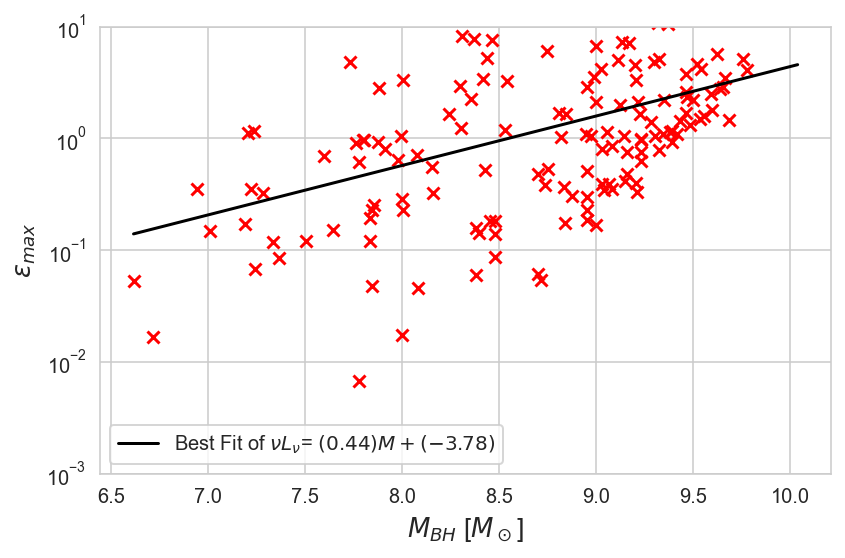

y_cal = 0.619418997303465*x+ -7.508310602107871 


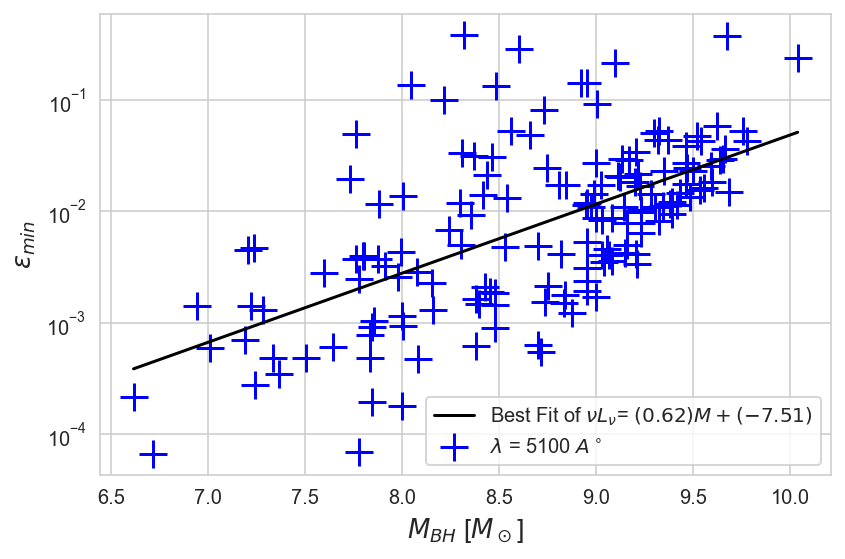

In [219]:
dattotsort3=total_lambda.sort_values('log_bh')
dattotsort3=dattotsort3.reset_index(drop=True)
x_totmax= dattotsort3['log_bh'].values
y_totmax= np.log10(dattotsort3['epsopt_max']).values
def obj(x, a,b):
    return a*(x)+b

guess = [min(y_totmax),min(y_totmax)]
parameters_totmax, _ = curve_fit(obj, x_totmax, y_totmax,guess)
fit_D_totmax = parameters_totmax[0]
fit_E_totmax = parameters_totmax[1]
# fit_F_totmax = parameters_totmax[2]
# fit_G512 = parameters512[3]

fit_obj_totmax = obj(x_totmax, fit_D_totmax,fit_E_totmax)

print('y_cal = %.15f*x+ %.15f ' % (fit_D_totmax,fit_E_totmax))

plt.plot(x_totmax, 10**fit_obj_totmax,'black',
        label=r'Best Fit of $\nu L_\nu$= $({})M+({})$'.format(round(fit_D_totmax,2), round(fit_E_totmax,2)))
plt.scatter(total_lambda['log_bh'],total_lambda['epsopt_max'],c='r',marker='x')
plt.ylabel('$\epsilon_{max}$',size=13)
plt.xlabel('$M_{BH}$ [$M_\odot$]',size=13)
plt.yscale('log')
plt.ylim(0.001,10)
plt.legend()
plt.tight_layout()
plt.show()
################################################################################################
dattotsort4=total_lambda.sort_values('log_bh')
dattotsort4=dattotsort4.reset_index(drop=True)
x_totmin = dattotsort4['log_bh'].values
y_totmin = np.log10(dattotsort4['epsopt_min']).values

def obj(x, a,b):
    return a*(x)+b

parameters_totmin, _ = curve_fit(obj, x_totmin, y_totmin)
fit_D_totmin = parameters_totmin[0]
fit_E_totmin = parameters_totmin[1]
# fit_F_totmax = parameters_totmax[2]
# fit_G512 = parameters512[3]

fit_obj_totmin = obj(x_totmin, fit_D_totmin,fit_E_totmin)

print('y_cal = %.15f*x+ %.15f ' % (fit_D_totmin,fit_E_totmin))

plt.plot(x_totmin, 10**fit_obj_totmin,'black',
        label=r'Best Fit of $\nu L_\nu$= $({})M+({})$'.format(round(fit_D_totmin,2), round(fit_E_totmin,2)))
plt.scatter(total_lambda['log_bh'],total_lambda['epsopt_min'],c='b',marker='+',s=200,label='$\lambda$ = 5100 $A^\circ$')
plt.ylabel('$\epsilon_{min}$',size=13)
plt.xlabel('$M_{BH}$ [$M_\odot$]',size=13)
plt.yscale('log')
# plt.ylim(0.0001,10)
plt.legend()
plt.tight_layout()
plt.show()

In [220]:
def tot_min(x):
    return fit_D_totmin*x + fit_E_totmin
def tot_max(x):
    return fit_D_totmax*x + fit_E_totmax

D:\Anaconda\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


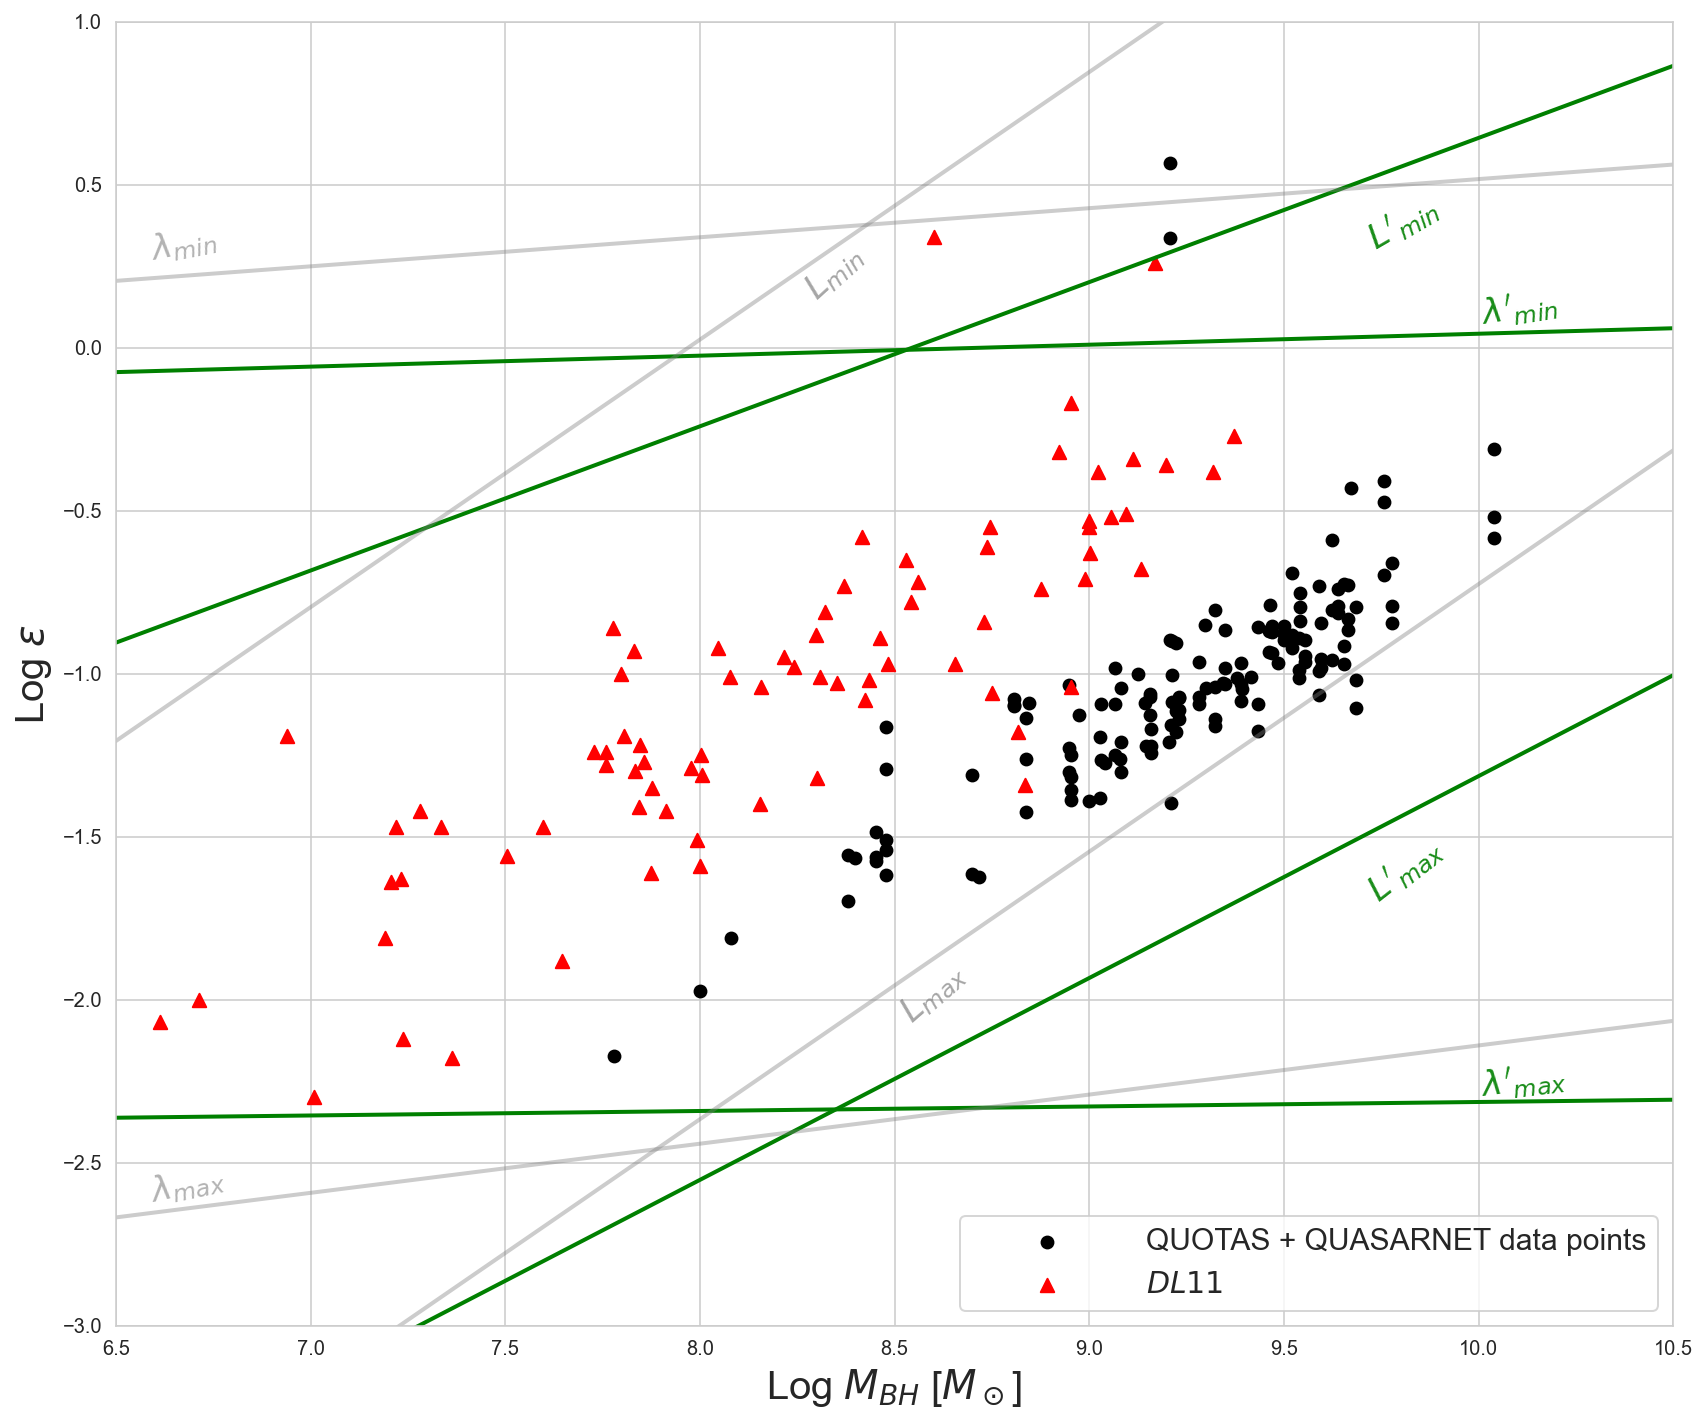

In [222]:
fig,ax= plt.subplots(figsize=(12, 10))
total_lambda_sort=total_lambda.sort_values('log_bh')
x_lambda = np.linspace(6,11,100)
plt.scatter(df_standard['log_bh'],np.log10(df_standard['epsopt_3000']),c='k',s=35,label='QUOTAS + QUASARNET data points')
# plt.scatter(df_standard['log_bh'],np.log10(df_standard['epsopt_5100']),c='k',s=35)

plt.scatter(df_standard['log_bh'],np.log10(df_standard['epsopt_1350']),c='k',s=35)

plt.scatter(df_standard['log_bh'],np.log10(df_standard['epsopt_1700']),c='k',s=35)

plt.scatter(D11_standard['log_bh'],np.log10(D11_standard['epsopt']),c='r',s=45, label='$DL11$',marker='^')

plt.plot(x_lambda, tot_max(x_lambda),
         c='g',linestyle='solid',linewidth = 2)

plt.plot(x_lambda,  tot_min(x_lambda),
         c='g',linestyle='solid',linewidth = 2)

plt.plot(np.linspace(7.808362-3,10.828106+2,100),np.linspace(-0.131725,0.638218-0.5,100),
         c='g',linestyle='solid',linewidth = 2)

plt.plot(np.linspace(7.788037-3,10.804878+2,100),np.linspace(-2.385899,-1.625231-0.65,100),
         c='g',linestyle='solid',linewidth = 2)

plt.plot(np.linspace(6.207357859531773,8.18561872909699+3,100),
         np.linspace(-2.7122040072859743,-1.9617486338797814,100),
         linestyle='solid',c='grey',alpha=0.4,linewidth = 2)

plt.plot(np.linspace(8.262541806020067-2,9.836120401337793+3,100),
         np.linspace(0.18397063375170752,0.7704916921035405,100),
         linestyle='solid',c='grey',alpha=0.4,linewidth = 2)

plt.plot(x_lambda,d11_l_max(x_lambda),
         c='grey',alpha=0.4,linestyle='solid',linewidth = 2)

plt.plot(x_lambda,d11_l_min(x_lambda),
         c='grey',alpha=0.4,linewidth = 2)

plt.text(6.58, -2.62, "$\lambda_{max}$", rotation=12,
         fontsize = 17, color = 'grey',alpha=0.6)
plt.text(6.58, 0.27, "$\lambda_{min}$", rotation=11,
         fontsize = 17, color = 'grey',alpha=0.6)

plt.text(8.5, -2.07, "$L_{max}$", rotation=41,
         fontsize = 17, color = 'grey',alpha=0.7)
plt.text(8.255, 0.15, "$L_{min}$", rotation=42,
         fontsize = 17, color = 'grey',alpha=0.7)



plt.text(10, -2.3, "$\lambda'_{max}$", rotation=7,
         fontsize = 17, color = 'g',alpha=0.9)
plt.text(10, 0.07, "$\lambda'_{min}$", rotation=9,
         fontsize = 17, color = 'g',alpha=0.9)

plt.text(9.7, -1.7, "$L'_{max}$", rotation=38,
         fontsize = 17, color = 'g',alpha=0.9)
plt.text(9.7, 0.3, "$L'_{min}$", rotation=30,
         fontsize = 17, color = 'g',alpha=0.9)


plt.ylim(-3,1)
plt.xlim(6.5,10.5)
plt.ylabel('Log $\epsilon$',size=20)
plt.xlabel('Log $M_{BH}$ [$M_\odot$]',size=20)
plt.legend(loc='lower right',fontsize=15,handlelength=5)
plt.tight_layout()
plt.savefig('76_standard_vol_flux_all_lines_-3_1_dL11_qn_epsilon_vs_M_lambda_L_min_max_fits.pdf',dpi=600)
plt.show()